In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
# from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

# from sdtw_cuda_loss import SoftDTW

In [3]:
device = torch.device('cuda:0') #  if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/TIME/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Выгрузим датасет Volve и преобразуем данные

In [5]:
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [6]:
window = 64

In [7]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size window

X_list = []
for i in range(0, len(X_all) - window, 10):
    X_list.append(X_all[i : window + i])

    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

X_verif_list = X_list_minus
    
# X is an array with the shape = (N, window, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [8]:
from dataset import Main_dataset, Verification_dataset
from models_new_64 import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


### Загрузим датасет GAN

In [9]:
torch_dataset = Main_dataset(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)

In [10]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [12]:
# check
for idx, data_all in enumerate(train_loader):
    real_data, y = data_all
    print(real_data.shape)
    break

torch.Size([64, 5, 64])


### Cоздадим датасет для верификатора и загрузим его

In [13]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : window + i])
# преобразуем лист в массив с размерностью [20, window, 5]; 20 - количество скважин, window - размерность окна, 
#                                                   5 - количество столбцов = len(required_params)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)

import random
different_wells = []

for i in range(0, window * 230, window):
    different_wells.append(X_all[i : i + window])
    different_wells.append(X_all[i : i + window])
    different_wells.append(X_all[i : i + window])
    different_wells.append(X_all[i : i + window])

random.shuffle(different_wells)
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)

needed = []
for i in range(different_wells.shape[0]):
    needed.append([different_wells[i - 1], different_wells[i], 1])
    needed.append([similar_wells[i - 1], similar_wells[i], 0])

In [14]:
verif_dataset = Verification_dataset(needed)
verif_loader = DataLoader(verif_dataset, batch_size=64, shuffle=True)

In [15]:
# check
for time1, time2, label in verif_loader:
    print(time1.shape)
    print(time2.shape)
    print(label)
    break

torch.Size([64, 5, 64])
torch.Size([64, 5, 64])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0.])


### Train verification model

In [16]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).to(device)

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)

In [19]:
class VerificationLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(VerificationLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

criterion_verification = VerificationLoss()

Epoch [0/200] Loss V: 1.1219
Epoch [10/200] Loss V: 2.1151
Epoch [20/200] Loss V: 1.3532
Epoch [30/200] Loss V: 2.0646
Epoch [40/200] Loss V: 1.3453
Epoch [50/200] Loss V: 1.7365
Epoch [60/200] Loss V: 1.1074
Epoch [70/200] Loss V: 1.1023
Epoch [80/200] Loss V: 2.2602
Epoch [90/200] Loss V: 1.7195
Epoch [100/200] Loss V: 1.4575
Epoch [110/200] Loss V: 2.0376
Epoch [120/200] Loss V: 0.9233
Epoch [130/200] Loss V: 1.4573
Epoch [140/200] Loss V: 1.9130
Epoch [150/200] Loss V: 1.1554
Epoch [160/200] Loss V: 2.4494
Epoch [170/200] Loss V: 1.5547
Epoch [180/200] Loss V: 1.2901
Epoch [190/200] Loss V: 2.2868


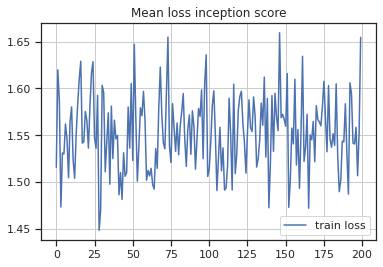

In [20]:
################################# TRAINING VERIFICATION #################################
def train_verification():
    best_train_acc = 0
    train_loss = []
    train_acc = []
    num_epochs = 200
    patience_counter = 0
    best_state_dict = None

    for epoch in range(num_epochs):
        model_verification.train();
        epoch_train_loss = []
        all_preds = []
        all_y = []
        for time1, time2, label in verif_loader:
            time1 = time1.to(device)
            time2 = time2.to(device)
            label = label.to(device)
            optimizer_verification.zero_grad()
            encoded_1 = model_verification(time1) 
            encoded_2 = model_verification(time2)
            loss = criterion_verification(encoded_1, encoded_2, label)
            epoch_train_loss.append(loss.item())
            loss.backward()
            optimizer_verification.step()
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Loss V: {loss.item():.4f}")
        train_loss.append(np.mean(epoch_train_loss))


    plt.plot(train_loss, label = 'train loss')
    plt.legend()
    plt.grid()
    plt.title('Mean loss inception score')
    plt.show()

    torch.save({
        'model_state_dict': model_verification.state_dict(),
    }, 
        'trained_models/model_verification_64window.pt'
    )
    
train_verification()

In [21]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).to(device)
checkpoint = torch.load('trained_models/model_verification_64window.pt')
model_verification.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Training models

In [22]:
# GANs hyperparamters
lr = 3e-4
batch_size = 128
num_epochs = 200
n_noise = window
n_critic = 1
fixed_noise = torch.randn((batch_size, len(required_params), window)).to(device)

In [23]:
disc_ms = Discriminator().to(device)
gen_ms = Generator().to(device)
disc_ms_osl = Discriminator().to(device)
gen_ms_osl = Generator().to(device)

disc_rms = Discriminator().to(device)
gen_rms = Generator().to(device)
disc_rms_osl = Discriminator().to(device)
gen_rms_osl = Generator().to(device)

disc_cba = Discriminator().to(device)
gen_cba = Generator().to(device)
disc_cba_osl = Discriminator().to(device)
gen_cba_osl = Generator().to(device)

disc_pcf = Discriminator().to(device)
gen_pcf = Generator().to(device)
disc_pcf_osl = Discriminator().to(device)
gen_pcf_osl = Generator().to(device)

disc_ed = Discriminator().to(device)
gen_ed = Generator().to(device)
disc_ed_osl = Discriminator().to(device)
gen_ed_osl = Generator().to(device)

disc_ssim = Discriminator().to(device)
gen_ssim = Generator().to(device)
disc_ssim_osl = Discriminator().to(device)
gen_ssim_osl = Generator().to(device)

criterion_gan_ms = nn.BCELoss()
criterion_gan_ms_osl = nn.BCELoss()

criterion_gan_rms = nn.BCELoss()
criterion_gan_rms_osl = nn.BCELoss()

criterion_gan_cba = nn.BCELoss()
criterion_gan_cba_osl = nn.BCELoss()

criterion_gan_pcf = nn.BCELoss()
criterion_gan_pcf_osl = nn.BCELoss()

criterion_gan_ed = nn.BCELoss()
criterion_gan_ed_osl = nn.BCELoss()

criterion_gan_ssim = nn.BCELoss()
criterion_gan_ssim_osl = nn.BCELoss()

D_opt_ms = torch.optim.Adam(disc_ms.parameters(), lr = lr)
G_opt_ms = torch.optim.Adam(gen_ms.parameters(), lr = lr)
D_opt_ms_osl = torch.optim.Adam(disc_ms_osl.parameters(), lr = lr)
G_opt_ms_osl = torch.optim.Adam(gen_ms_osl.parameters(), lr = lr)

D_opt_rms = torch.optim.Adam(disc_rms.parameters(), lr = lr)
G_opt_rms = torch.optim.Adam(gen_rms.parameters(), lr = lr)
D_opt_rms_osl = torch.optim.Adam(disc_rms_osl.parameters(), lr = lr)
G_opt_rms_osl = torch.optim.Adam(gen_rms_osl.parameters(), lr = lr)

D_opt_cba = torch.optim.Adam(disc_cba.parameters(), lr = lr)
G_opt_cba = torch.optim.Adam(gen_cba.parameters(), lr = lr)
D_opt_cba_osl = torch.optim.Adam(disc_cba_osl.parameters(), lr = lr)
G_opt_cba_osl = torch.optim.Adam(gen_cba_osl.parameters(), lr = lr)

D_opt_pcf = torch.optim.Adam(disc_pcf.parameters(), lr = lr)
G_opt_pcf = torch.optim.Adam(gen_pcf.parameters(), lr = lr)
D_opt_pcf_osl = torch.optim.Adam(disc_pcf_osl.parameters(), lr = lr)
G_opt_pcf_osl = torch.optim.Adam(gen_pcf_osl.parameters(), lr = lr)

D_opt_ed = torch.optim.Adam(disc_ed.parameters(), lr = lr)
G_opt_ed = torch.optim.Adam(gen_ed.parameters(), lr = lr)
D_opt_ed_osl = torch.optim.Adam(disc_ed_osl.parameters(), lr = lr)
G_opt_ed_osl = torch.optim.Adam(gen_ed_osl.parameters(), lr = lr)

D_opt_ssim = torch.optim.Adam(disc_ssim.parameters(), lr = lr)
G_opt_ssim = torch.optim.Adam(gen_ssim.parameters(), lr = lr)
D_opt_ssim_osl = torch.optim.Adam(disc_ssim_osl.parameters(), lr = lr)
G_opt_ssim_osl = torch.optim.Adam(gen_ssim_osl.parameters(), lr = lr)

### training the model

In [24]:
def train(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate_list = []
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    V_losses2 = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)

            # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(real_data)
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake)
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            
            # verificator loss
            model_verification.eval()
            embeding_fake = model_verification(fake)
            embeding_real = model_verification(real_data)
            label = torch.ones(batch_size).to(device)
            loss_verif = criterion_verification(embeding_real, embeding_fake, label)
            V_losses.append(loss_verif.item())
            
            # de-identification rate
            pred_equal_y = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
            pred_max = torch.max(embeding_fake, dim = 1)[0]
            de_ident_rate_list.append((pred_equal_y < pred_max).float().mean())
            
            # similarity loss
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake)
            else:
                loss_regul = criterion_regulator()(real_data, fake) / 1000
            R_losses.append(loss_regul.item())
            
            D_loss = (D_loss_1 + D_loss_2) / 2 + 0.1 * loss_verif.detach() + 0.1 * loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() # retain_graph = True
            D_opt.step()
            
            # GENERATOR TRAINING == maximize D(G(noise))
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(real_data)
            output = disc(fake)
            G_loss = criterion_gan(output, torch.ones_like(output))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")


            step += 1
            
    de_ident_rate = (sum(de_ident_rate_list) / len(de_ident_rate_list)).item()
    str_simil = 1 - sum(R_losses) / len(R_losses)
                    
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': str_simil
    }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses, V_losses2

In [25]:
def train_osl(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate_list = []
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)

            # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(real_data)
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.full((disc_real.shape), 0.9).to(device))
            disc_fake = disc(fake)
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            
            # verificator loss
            model_verification.eval()
            embeding_fake = model_verification(fake)
            embeding_real = model_verification(real_data)
            label = torch.ones(batch_size).to(device)
            loss_verif = criterion_verification(embeding_real, embeding_fake, label)
            V_losses.append(loss_verif.item())
            
            # de-identification rate
            pred_equal_y = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
            pred_max = torch.max(embeding_fake, dim = 1)[0]
            de_ident_rate_list.append((pred_equal_y < pred_max).float().mean())
            
            # similarity loss
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake)
            else:
                loss_regul = criterion_regulator()(real_data, fake) / 1000
            R_losses.append(loss_regul.item())
            
            D_loss = (D_loss_1 + D_loss_2) / 2 + 0.1 * loss_verif.detach() + 0.1 * loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() 
            D_opt.step()
            
            # GENERATOR TRAINING == maximize D(G(noise))
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(real_data)
            output = disc(fake)
            G_loss = criterion_gan(output, torch.full((output.shape), 0.9).to(device))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")


            step += 1
            
    de_ident_rate = (sum(de_ident_rate_list) / len(de_ident_rate_list)).item()
    str_simil = 1 - sum(R_losses) / len(R_losses)
                    
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': str_simil
    }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses

---

### models training

In [24]:
# losses_ms = train(loader = train_loader, 
#                   gen = gen_ms, 
#                   disc = disc_ms, 
#                   criterion_gan = criterion_gan_ms, 
#                   G_opt = G_opt_ms, 
#                   D_opt = D_opt_ms, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Mean_similarity_loss,
#                   save_PATH = 'trained_models/gan_ms_64.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

In [25]:
gen_ms = Generator().to(device)
disc_ms = Discriminator().to(device)

checkpoint_ms = torch.load('trained_models/gan_ms_osl_64_tuned.pt')

gen_ms.load_state_dict(checkpoint_ms['gen_state_dict'])
disc_ms.load_state_dict(checkpoint_ms['disc_state_dict'])
de_ident_rate_ms = checkpoint_ms['de_ident_rate']
str_simil_ms = checkpoint_ms['str_simil']
print(de_ident_rate_ms)
print(str_simil_ms)

0.9532290101051331
0.7384218254963677


In [26]:
losses_ms_osl = train_osl(loader = train_loader, 
                  gen = gen_ms_osl, 
                  disc = disc_ms_osl, 
                  criterion_gan = criterion_gan_ms_osl, 
                  G_opt = G_opt_ms_osl, 
                  D_opt = D_opt_ms_osl, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ms_osl_64_tuned_new_ver.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/200] Batch 82/83 Loss D: 0.6915, Loss G: 3.7146, Loss V: 3.8745, Loss R: 0.1567
Epoch [10/200] Batch 82/83 Loss D: 0.5770, Loss G: 7.1311, Loss V: 3.8783, Loss R: 0.1953
Epoch [20/200] Batch 82/83 Loss D: 0.5797, Loss G: 6.8643, Loss V: 3.8998, Loss R: 0.2317
Epoch [30/200] Batch 82/83 Loss D: 0.5841, Loss G: 8.2014, Loss V: 3.9202, Loss R: 0.2161
Epoch [40/200] Batch 82/83 Loss D: 0.5831, Loss G: 8.4587, Loss V: 3.9262, Loss R: 0.2231
Epoch [50/200] Batch 82/83 Loss D: 0.5761, Loss G: 8.4709, Loss V: 3.8970, Loss R: 0.2243
Epoch [60/200] Batch 82/83 Loss D: 0.5831, Loss G: 9.5282, Loss V: 3.9281, Loss R: 0.2693
Epoch [70/200] Batch 82/83 Loss D: 0.5780, Loss G: 8.3054, Loss V: 3.9032, Loss R: 0.2228
Epoch [80/200] Batch 82/83 Loss D: 0.5750, Loss G: 8.0046, Loss V: 3.8352, Loss R: 0.2459
Epoch [90/200] Batch 82/83 Loss D: 0.5720, Loss G: 7.9236, Loss V: 3.8946, Loss R: 0.1966
Epoch [100/200] Batch 82/83 Loss D: 0.5714, Loss G: 11.0351, Loss V: 3.8796, Loss R: 0.2074
Epoch [11

In [27]:
gen_ms_osl = Generator().to(device)
disc_ms_osl = Discriminator().to(device)

checkpoint_ms_osl = torch.load('trained_models/gan_ms_osl_64_tuned_new_ver.pt')

gen_ms_osl.load_state_dict(checkpoint_ms_osl['gen_state_dict'])
disc_ms_osl.load_state_dict(checkpoint_ms_osl['disc_state_dict'])
de_ident_rate_ms_osl = checkpoint_ms_osl['de_ident_rate']
str_simil_ms_osl = checkpoint_ms_osl['str_simil']
print(de_ident_rate_ms_osl)
print(str_simil_ms_osl)

0.9519139528274536
0.7556934130757329


### root_mean_square

In [28]:
losses_rms = train(loader = train_loader, 
                  gen = gen_rms, 
                  disc = disc_rms, 
                  criterion_gan = criterion_gan_rms, 
                  G_opt = G_opt_rms,  
                  D_opt = D_opt_rms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Root_mean_square_similarity_loss,
                  save_PATH = 'trained_models/gan_rms_64.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

In [26]:
gen_rms = Generator().to(device)
disc_rms = Discriminator().to(device)

checkpoint_rms = torch.load('trained_models/gan_rms_osl_64_tuned.pt')

gen_rms.load_state_dict(checkpoint_rms['gen_state_dict'])
disc_rms.load_state_dict(checkpoint_rms['disc_state_dict'])
de_ident_rate_rms = checkpoint_rms['de_ident_rate']
str_simil_rms = checkpoint_rms['str_simil']
print(de_ident_rate_rms)
print(str_simil_rms)

0.9532769322395325
0.49808430239737755


In [27]:
# losses_rms_osl = train_osl(loader = train_loader, 
#                   gen = gen_rms_osl, 
#                   disc = disc_rms_osl, 
#                   criterion_gan = criterion_gan_rms_osl, 
#                   G_opt = G_opt_rms_osl,  
#                   D_opt = D_opt_rms_osl, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Root_mean_square_similarity_loss,
#                   save_PATH = 'trained_models/gan_rms_osl_64_tuned.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

In [27]:
gen_rms_osl = Generator().to(device)
disc_rms_osl = Discriminator().to(device)

checkpoint_rms_osl = torch.load('trained_models/gan_rms_osl_64_tuned.pt')

gen_rms_osl.load_state_dict(checkpoint_rms_osl['gen_state_dict'])
disc_rms_osl.load_state_dict(checkpoint_rms_osl['disc_state_dict'])
de_ident_rate_rms_osl = checkpoint_rms_osl['de_ident_rate']
str_simil_rms_osl = checkpoint_rms_osl['str_simil']
print(de_ident_rate_rms_osl)
print(str_simil_rms_osl)

0.9532769322395325
0.49808430239737755


### coisine_between_angles

In [32]:
# losses_cba = train(loader = train_loader, 
#                   gen = gen_cba, 
#                   disc = disc_cba, 
#                   criterion_gan = criterion_gan_cba, 
#                   G_opt = G_opt_cba, 
#                   D_opt = D_opt_cba, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Coisine_between_angles_loss,
#                   save_PATH = 'trained_models/gan_cba_64.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

In [29]:
gen_cba = Generator().to(device)
disc_cba = Discriminator().to(device)

checkpoint_cba = torch.load('trained_models/gan_cba_osl_64_tuned.pt')

gen_cba.load_state_dict(checkpoint_cba['gen_state_dict'])
disc_cba.load_state_dict(checkpoint_cba['disc_state_dict'])
de_ident_rate_cba = checkpoint_cba['de_ident_rate']
str_simil_cba = checkpoint_cba['str_simil']

In [28]:
# losses_cba_osl = train_osl(loader = train_loader, 
#                   gen = gen_cba_osl, 
#                   disc = disc_cba_osl, 
#                   criterion_gan = criterion_gan_cba_osl, 
#                   G_opt = G_opt_cba_osl, 
#                   D_opt = D_opt_cba_osl, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Coisine_between_angles_loss,
#                   save_PATH = 'trained_models/gan_cba_osl_64_tuned.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

Epoch [0/200] Batch 82/83 Loss D: 0.6510, Loss G: 4.3523, Loss V: 3.8434, Loss R: 0.0068
Epoch [10/200] Batch 82/83 Loss D: 0.5786, Loss G: 5.7784, Loss V: 3.8770, Loss R: 0.0837
Epoch [20/200] Batch 82/83 Loss D: 0.5690, Loss G: 6.8399, Loss V: 3.9070, Loss R: 0.1183
Epoch [30/200] Batch 82/83 Loss D: 0.5690, Loss G: 7.0012, Loss V: 3.8310, Loss R: 0.1495
Epoch [40/200] Batch 82/83 Loss D: 0.5615, Loss G: 7.1688, Loss V: 3.8911, Loss R: 0.0777
Epoch [50/200] Batch 82/83 Loss D: 0.5514, Loss G: 6.8207, Loss V: 3.9140, Loss R: -0.0588
Epoch [60/200] Batch 82/83 Loss D: 0.5709, Loss G: 6.2073, Loss V: 3.9114, Loss R: 0.0349
Epoch [70/200] Batch 82/83 Loss D: 0.5647, Loss G: 12.9381, Loss V: 3.9021, Loss R: 0.0509
Epoch [80/200] Batch 82/83 Loss D: 0.6346, Loss G: 6.4223, Loss V: 3.9103, Loss R: 0.0793
Epoch [90/200] Batch 82/83 Loss D: 0.5653, Loss G: 7.5079, Loss V: 3.8731, Loss R: 0.1342
Epoch [100/200] Batch 82/83 Loss D: 0.5751, Loss G: 9.1532, Loss V: 3.8993, Loss R: 0.2002
Epoch [1

In [29]:
gen_cba_osl = Generator().to(device)
disc_cba_osl = Discriminator().to(device)

checkpoint_cba_osl = torch.load('trained_models/gan_cba_osl_64_tuned.pt')

gen_cba_osl.load_state_dict(checkpoint_cba_osl['gen_state_dict'])
disc_cba_osl.load_state_dict(checkpoint_cba_osl['disc_state_dict'])
de_ident_rate_cba_osl = checkpoint_cba_osl['de_ident_rate']
str_simil_cba_osl = checkpoint_cba_osl['str_simil']

### pearson_corr_funct

In [33]:
losses_pcf = train(loader = train_loader, 
                  gen = gen_pcf, 
                  disc = disc_pcf, 
                  criterion_gan = criterion_gan_pcf, 
                  G_opt = G_opt_pcf, 
                  D_opt = D_opt_pcf, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Pearson_corr_funct_loss,
                  save_PATH = 'trained_models/gan_ms_osl_64_tuned_new_ver.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/200] Batch 82/83 Loss D: 0.5013, Loss G: 5.1732, Loss V: 3.8686, Loss R: 0.1238
Epoch [10/200] Batch 82/83 Loss D: 0.3874, Loss G: 7.7568, Loss V: 3.8653, Loss R: -0.0230
Epoch [20/200] Batch 82/83 Loss D: 0.3867, Loss G: 11.7014, Loss V: 3.9100, Loss R: -0.0844
Epoch [30/200] Batch 82/83 Loss D: 0.3823, Loss G: 10.7422, Loss V: 3.9051, Loss R: -0.0844
Epoch [40/200] Batch 82/83 Loss D: 0.3852, Loss G: 10.3656, Loss V: 3.9124, Loss R: -0.0746
Epoch [50/200] Batch 82/83 Loss D: 0.4071, Loss G: 4.9929, Loss V: 3.9203, Loss R: -0.0451
Epoch [60/200] Batch 82/83 Loss D: 0.4041, Loss G: 5.1973, Loss V: 3.9008, Loss R: 0.0505
Epoch [70/200] Batch 82/83 Loss D: 0.3910, Loss G: 9.4676, Loss V: 3.8904, Loss R: -0.0042
Epoch [80/200] Batch 82/83 Loss D: 0.4059, Loss G: 13.0673, Loss V: 3.8833, Loss R: 0.1544
Epoch [90/200] Batch 82/83 Loss D: 0.4224, Loss G: 11.5660, Loss V: 3.9060, Loss R: 0.0396
Epoch [100/200] Batch 82/83 Loss D: 0.3989, Loss G: 10.5304, Loss V: 3.8903, Loss R: 0.067

In [35]:
gen_pcf = Generator().to(device)
disc_pcf = Discriminator().to(device)

checkpoint_pcf = torch.load('trained_models/gan_ms_osl_64_tuned_new_ver.pt')

gen_pcf.load_state_dict(checkpoint_pcf['gen_state_dict'])
disc_pcf.load_state_dict(checkpoint_pcf['disc_state_dict'])
de_ident_rate_pcf = checkpoint_pcf['de_ident_rate']
str_simil_pcf = checkpoint_pcf['str_simil']
print(de_ident_rate_pcf)
print(str_simil_pcf)

0.9520186185836792
0.98699736140633


In [30]:
# losses_pcf_osl = train_osl(loader = train_loader, 
#                   gen = gen_pcf_osl, 
#                   disc = disc_pcf_osl, 
#                   criterion_gan = criterion_gan_pcf_osl, 
#                   G_opt = G_opt_pcf_osl, 
#                   D_opt = D_opt_pcf_osl, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Pearson_corr_funct_loss,
#                   save_PATH = 'trained_models/gan_pcf_osl_64_tuned.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

Epoch [0/200] Batch 82/83 Loss D: 0.6052, Loss G: 4.5288, Loss V: 3.8278, Loss R: -0.0138
Epoch [10/200] Batch 82/83 Loss D: 0.5720, Loss G: 7.3821, Loss V: 3.9200, Loss R: -0.0474
Epoch [20/200] Batch 82/83 Loss D: 0.5587, Loss G: 8.0340, Loss V: 3.8723, Loss R: 0.0620
Epoch [30/200] Batch 82/83 Loss D: 0.5602, Loss G: 8.1799, Loss V: 3.8964, Loss R: 0.0082
Epoch [40/200] Batch 82/83 Loss D: 0.5588, Loss G: 8.2175, Loss V: 3.9167, Loss R: 0.0110
Epoch [50/200] Batch 82/83 Loss D: 0.5590, Loss G: 10.5708, Loss V: 3.8478, Loss R: 0.1038
Epoch [60/200] Batch 82/83 Loss D: 0.5431, Loss G: 9.9377, Loss V: 3.9013, Loss R: -0.0991
Epoch [70/200] Batch 82/83 Loss D: 0.5528, Loss G: 10.7894, Loss V: 3.8292, Loss R: 0.0704
Epoch [80/200] Batch 82/83 Loss D: 0.5580, Loss G: 8.2878, Loss V: 3.8988, Loss R: 0.0380
Epoch [90/200] Batch 82/83 Loss D: 0.5636, Loss G: 9.6630, Loss V: 3.8681, Loss R: 0.1260
Epoch [100/200] Batch 82/83 Loss D: 0.5634, Loss G: 8.2566, Loss V: 3.9269, Loss R: 0.0266
Epoch

In [31]:
gen_pcf_osl = Generator().to(device)
disc_pcf_osl = Discriminator().to(device)

checkpoint_pcf_osl = torch.load('trained_models/gan_pcf_osl_64_tuned.pt')

gen_pcf_osl.load_state_dict(checkpoint_pcf_osl['gen_state_dict'])
disc_pcf_osl.load_state_dict(checkpoint_pcf_osl['disc_state_dict'])
de_ident_rate_pcf_osl = checkpoint_pcf_osl['de_ident_rate']
str_simil_pcf_osl = checkpoint_pcf_osl['str_simil']
print(de_ident_rate_pcf_osl)
print(str_simil_pcf_osl)

0.9529314041137695
0.9491346803375278


### eucledian_distance

In [40]:
# losses_ed = train(loader = train_loader, 
#                   gen = gen_ed, 
#                   disc = disc_ed, 
#                   criterion_gan = criterion_gan_ed, 
#                   G_opt = G_opt_ed, 
#                   D_opt = D_opt_ed, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Eucledian_distance_loss,
#                   save_PATH = 'trained_models/gan_ed_64.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

In [31]:
gen_ed = Generator().to(device)
disc_ed = Discriminator().to(device)

checkpoint_ed = torch.load('trained_models/gan_ed_osl_64_tuned.pt')

gen_ed.load_state_dict(checkpoint_ed['gen_state_dict'])
disc_ed.load_state_dict(checkpoint_ed['disc_state_dict'])
de_ident_rate_ed = checkpoint_ed['de_ident_rate']
str_simil_ed = checkpoint_ed['str_simil']
print(de_ident_rate_ed)
print(str_simil_ed)

0.9531694650650024
0.8582920684028102


In [32]:
# losses_ed_osl = train_osl(loader = train_loader, 
#                   gen = gen_ed_osl, 
#                   disc = disc_ed_osl, 
#                   criterion_gan = criterion_gan_ed_osl, 
#                   G_opt = G_opt_ed_osl, 
#                   D_opt = D_opt_ed_osl, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Eucledian_distance_loss,
#                   save_PATH = 'trained_models/gan_ed_osl_64_tuned.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

Epoch [0/200] Batch 82/83 Loss D: 0.5956, Loss G: 5.2084, Loss V: 3.8915, Loss R: 0.1185
Epoch [10/200] Batch 82/83 Loss D: 0.5821, Loss G: 6.2044, Loss V: 3.9021, Loss R: 0.1042
Epoch [20/200] Batch 82/83 Loss D: 0.5814, Loss G: 7.6824, Loss V: 3.8884, Loss R: 0.1306
Epoch [30/200] Batch 82/83 Loss D: 0.5722, Loss G: 8.2439, Loss V: 3.9118, Loss R: 0.1048
Epoch [40/200] Batch 82/83 Loss D: 0.5775, Loss G: 7.5462, Loss V: 3.8944, Loss R: 0.1384
Epoch [50/200] Batch 82/83 Loss D: 0.5685, Loss G: 8.8385, Loss V: 3.9485, Loss R: 0.0764
Epoch [60/200] Batch 82/83 Loss D: 0.5646, Loss G: 9.7350, Loss V: 3.9103, Loss R: 0.1007
Epoch [70/200] Batch 82/83 Loss D: 0.5656, Loss G: 10.9120, Loss V: 3.9248, Loss R: 0.0923
Epoch [80/200] Batch 82/83 Loss D: 0.5663, Loss G: 9.8029, Loss V: 3.9023, Loss R: 0.1215
Epoch [90/200] Batch 82/83 Loss D: 0.5725, Loss G: 9.4749, Loss V: 3.8761, Loss R: 0.2122
Epoch [100/200] Batch 82/83 Loss D: 0.5626, Loss G: 10.0257, Loss V: 3.8736, Loss R: 0.1213
Epoch [1

In [33]:
gen_ed_osl = Generator().to(device)
disc_ed_osl = Discriminator().to(device)

checkpoint_ed_osl = torch.load('trained_models/gan_ed_osl_64_tuned.pt')

gen_ed_osl.load_state_dict(checkpoint_ed_osl['gen_state_dict'])
disc_ed_osl.load_state_dict(checkpoint_ed_osl['disc_state_dict'])
de_ident_rate_ed_osl = checkpoint_ed_osl['de_ident_rate']
str_simil_ed_osl = checkpoint_ed_osl['str_simil']
print(de_ident_rate_ed_osl)
print(str_simil_ed_osl)

0.9531694650650024
0.8582920684028102


### ssim

In [32]:
# losses_ssim = train(loader = train_loader, 
#                     gen = gen_ssim, 
#                     disc = disc_ssim, 
#                     criterion_gan = criterion_gan_ssim, 
#                     G_opt = G_opt_ssim, 
#                     D_opt = D_opt_ssim, 
#                     model_verification = model_verification, 
#                     criterion_verification = criterion_verification, 
#                     criterion_regulator = SSIM_1d_conv,
#                     save_PATH = 'trained_models/gan_ssim.pt', 
#                     lr = lr, 
#                     batch_size = batch_size, 
#                     num_epochs = num_epochs, 
#                     n_noise = n_noise, 
#                     n_critic = n_critic)

In [33]:
# gen_ssim = Generator().to(device)
# disc_ssim = Discriminator().to(device)

# checkpoint_ssim = torch.load('trained_models/gan_ssim.pt')

# gen_ssim.load_state_dict(checkpoint_ssim['gen_state_dict'])
# disc_ssim.load_state_dict(checkpoint_ssim['disc_state_dict'])
# de_ident_rate_ssim = checkpoint_ssim['de_ident_rate']
# str_simil_ssim = checkpoint_ssim['str_simil']

In [34]:
# plt.figure(figsize=(10, 7))
# plt.plot(losses_ssim[0], label = 'G_losses')
# plt.plot(losses_ssim[1], label = 'D_losses')
# # plt.plot(losses_ssim[2], label = 'R_losses')
# # plt.plot(losses_ssim[3], label = 'V_losses')
# plt.legend()
# plt.grid()
# plt.show()

### Figure

In [54]:
reg_names = ['Mean_similarity_loss', 
             'Root_mean_square_similarity_loss', 
             'Coisine_between_angles_loss', 
             'Pearson_corr_funct_loss', 
             'Eucledian_distance_loss', 
#              'SSIM_1d_conv'
            ]

regul_loss_dict = dict.fromkeys(reg_names, [])
regul_loss_list = [Mean_similarity_loss, 
                   Root_mean_square_similarity_loss, 
                   Coisine_between_angles_loss,
                   Pearson_corr_funct_loss, 
                   Eucledian_distance_loss, 
#                    SSIM_1d_conv
                  ]


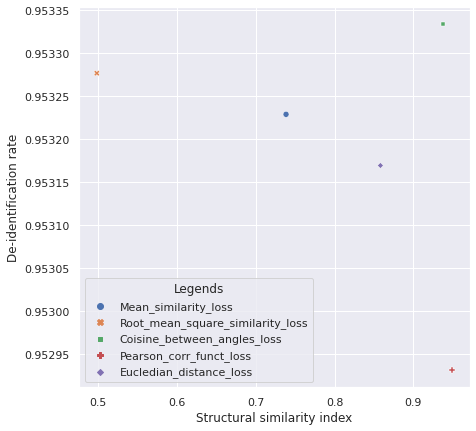

In [55]:
sns.set_theme()
data = pd.DataFrame({
    'Structural similarity index': [str_simil_ms_osl, 
                                    str_simil_rms_osl, 
                                    str_simil_cba_osl, 
                                    str_simil_pcf_osl, 
                                    str_simil_ed_osl, 
#                                     str_simil_ssim
                                   ],
    'De-identification rate': [de_ident_rate_ms_osl, 
                               de_ident_rate_rms_osl, 
                               de_ident_rate_cba_osl, 
                               de_ident_rate_pcf_osl, 
                               de_ident_rate_ed_osl, 
#                                de_ident_rate_ssim
                              ],
    'Legends': reg_names})

plt.figure(figsize = (7, 7))
sns.scatterplot(data=data, x="Structural similarity index", 
                y="De-identification rate", 
                hue = 'Legends', 
                style="Legends",
                legend='brief');
plt.savefig('images/Osl_GAN_window_64_trade_off_tuned.png')

## test

In [28]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [29]:
test_well = wells[22]
test_well

'well_17.json'

In [30]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [31]:
y_name = 'DEPTH'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


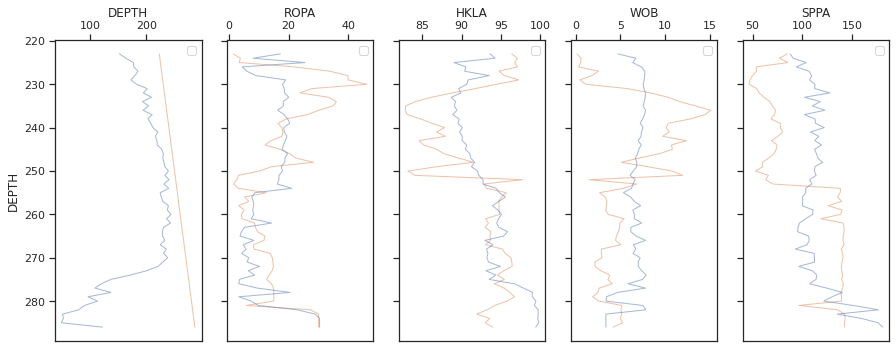

In [36]:
###################### CHECK ######################
t = X_test[y_name][:64].astype(float).values
x = X_test[required_params][:64].values

mean_x = x.mean(axis=0)
x = (x - mean_x) / scales_vectors
with torch.no_grad():
    x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
    z = gen_pcf(x.transpose(1, 2))

z = z.transpose(1, 2)[0].cpu().data.numpy()*scales_vectors + mean_x

plt.figure(figsize=(15, 5))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
    plt.plot(X_test[curve_name][:64].astype(float).values, t, lw=1, color='C1', alpha=0.5)
    plt.plot(z[:, i].astype(float), t, lw=1, color='C0', alpha=0.5, label = '')
    plt.legend()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')
plt.tight_layout()

In [59]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = gen_cba_osl(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [60]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [61]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:02<00:00, 349.83it/s]


837it [00:00, 192437.23it/s]
/tmp/ipykernel_32098/1785723542.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 198329.61it/s]
/tmp/ipykernel_32098/1785723542.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 201124.75it/s]
/tmp/ipykernel_32098/1785723542.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 223635.65it/s]
/tmp/ipykernel_32098/1785723542.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 192173.88it/s]
/tmp/ipykernel_32098/1785723542.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


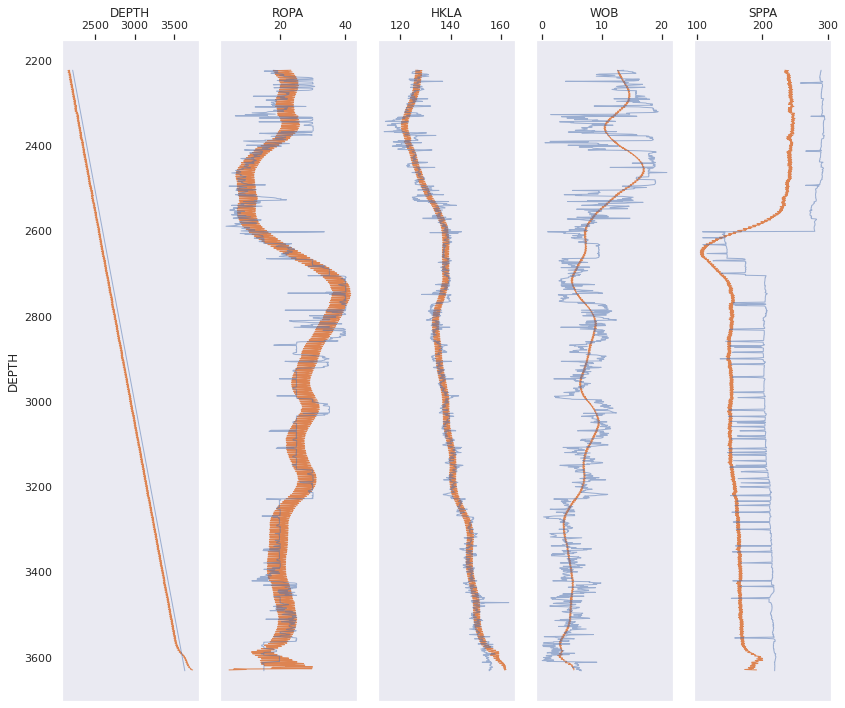

In [64]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    plt.plot(A[not_nan_inds][2000:], t[not_nan_inds][2000:], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values[2000:], t[2000:], lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
plt.savefig('images/MS_whole.png')